In [1]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
 
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
'''
Y =  np.load("../leabra/y_16_100.npy")
X = np.load("../leabra/x_16_100.npy")

rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(Y)

'''

#This uses the preprocessing library to import and augment images. The images are then converted to a simple numpy array
datagen = image.ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    dtype="float32"
)

dataset = datagen.flow_from_directory(
    "../leabra",
    target_size=(100,100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
)

X = np.array(dataset.__getitem__(0)[0], dtype="float32")
Y = np.array(dataset.__getitem__(0)[1], dtype="float32")

Found 1598 images belonging to 2 classes.


In [4]:
input_shape = X[0].shape
output_shape = Y.shape[1]
print(input_shape)
print(output_shape)

(100, 100, 1)
2


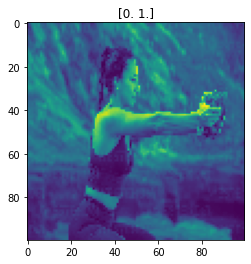

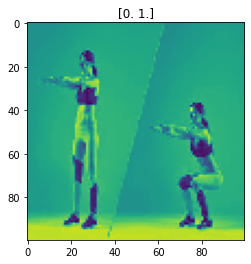

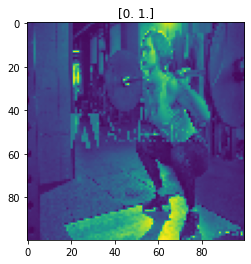

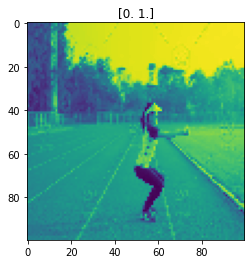

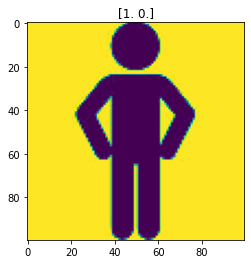

In [5]:
    for i in range(5):
        #plt.imshow(image.array_to_img(train.__getitem__(0)[0][i]))
        #plt.title(str(train.__getitem__(0)[1][i]))
        plt.imshow(image.array_to_img(X[i,:,:,:]))
        plt.title(str(Y[i]))
        plt.show()

[0. 1.]


In [6]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(512, (6,6), activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(256, (4,4), activation='relu'))
model.add(keras.layers.BatchNormalization(momentum=0.35))
model.add(keras.layers.MaxPooling2D(pool_size=(4,4)))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(output_shape, activation='softmax'))
 
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy()])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 95, 512)       18944     
_________________________________________________________________
batch_normalization (BatchNo (None, 95, 95, 512)       2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 512)       0         
_________________________________________________________________
flatten (Flatten)            (None, 270848)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               34668672  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [7]:
batch_size = 32
epochs = 50
history = model.fit(X, Y,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_split=0.2
)    

Epoch 1/50
40/40 [==============================] - 6s 71ms/step - loss: 28.1316 - categorical_accuracy: 0.5305 - val_loss: 8.7515 - val_categorical_accuracy: 0.6438
Epoch 2/50
40/40 [==============================] - 2s 62ms/step - loss: 6.3281 - categorical_accuracy: 0.6537 - val_loss: 2.0832 - val_categorical_accuracy: 0.6500
Epoch 3/50
40/40 [==============================] - 2s 60ms/step - loss: 1.6384 - categorical_accuracy: 0.6780 - val_loss: 1.0444 - val_categorical_accuracy: 0.6656
Epoch 4/50
40/40 [==============================] - 2s 60ms/step - loss: 0.7096 - categorical_accuracy: 0.6892 - val_loss: 1.0717 - val_categorical_accuracy: 0.7156
Epoch 5/50
40/40 [==============================] - 2s 60ms/step - loss: 1.0968 - categorical_accuracy: 0.7330 - val_loss: 1.5071 - val_categorical_accuracy: 0.6594
Epoch 6/50
40/40 [==============================] - 2s 61ms/step - loss: 0.9747 - categorical_accuracy: 0.7085 - val_loss: 1.3438 - val_categorical_accuracy: 0.6844
Epoch 7/5

Test loss: 0.28444570302963257
Test accuracy: 0.9468085169792175


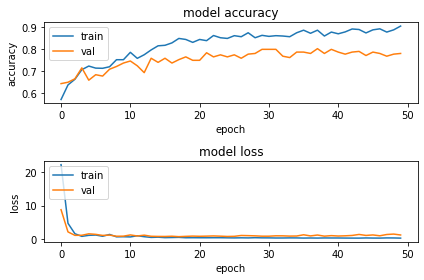

In [8]:
score = model.evaluate(X, Y, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:",score[1])

plt.figure(1) 

# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

### Verify the predictions being made
---

30
55


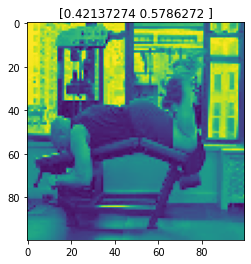

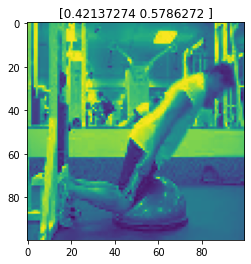

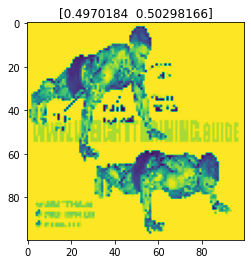

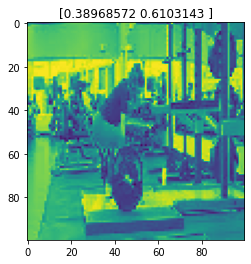

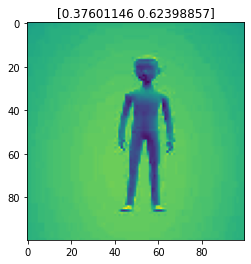

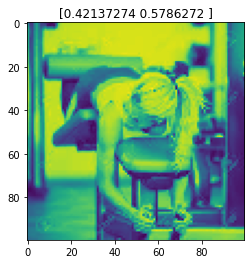

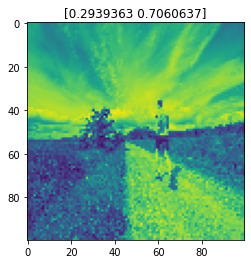

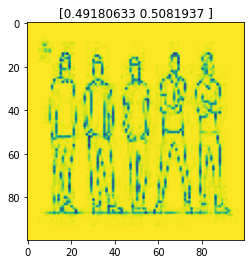

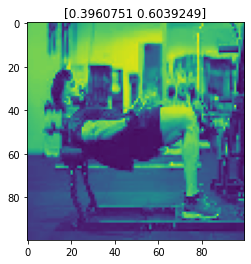

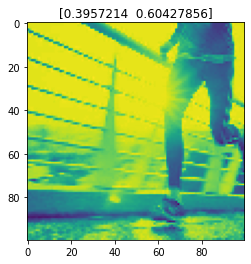

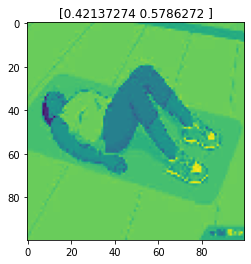

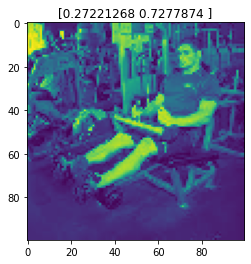

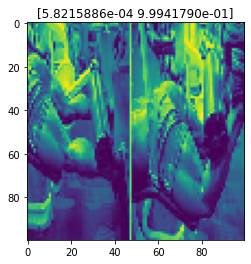

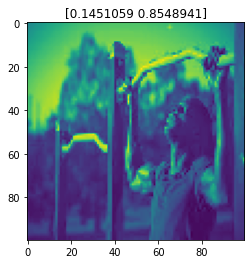

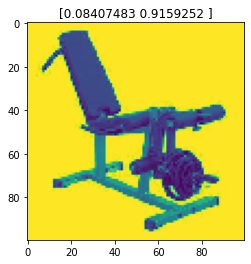

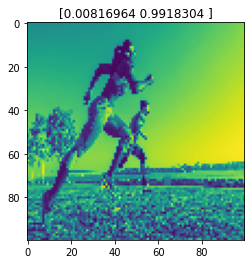

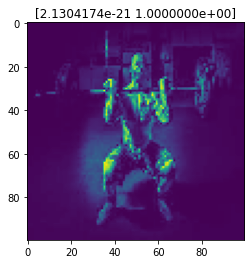

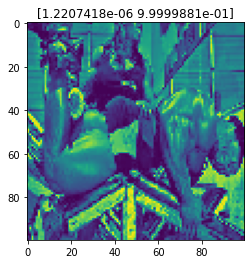

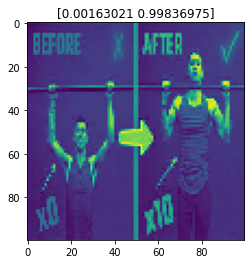

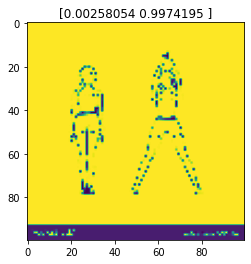

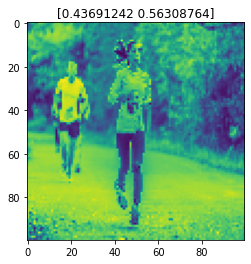

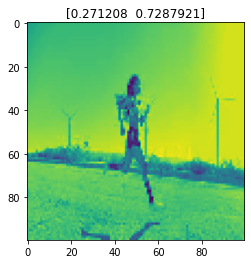

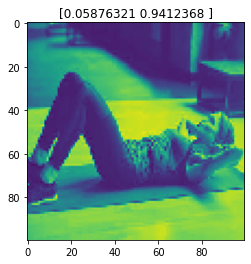

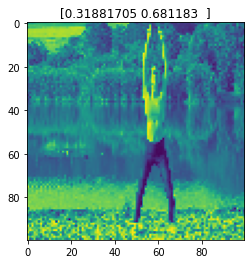

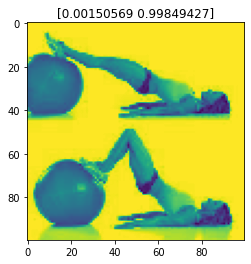

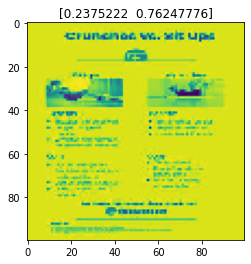

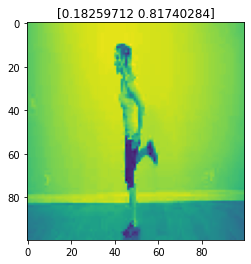

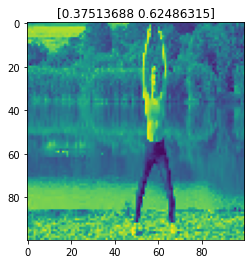

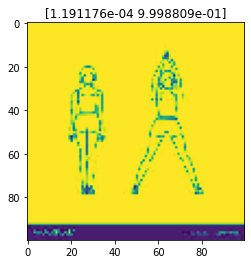

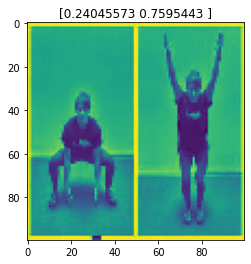

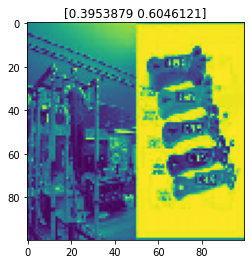

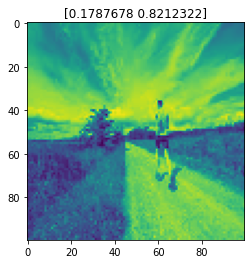

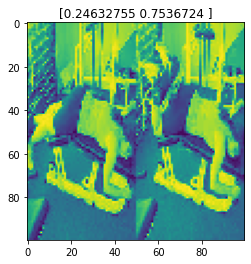

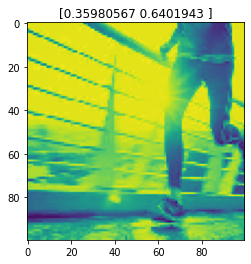

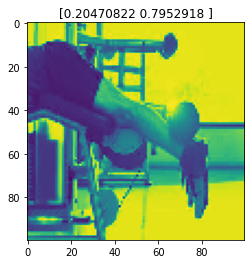

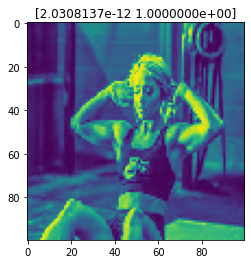

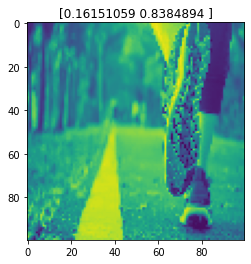

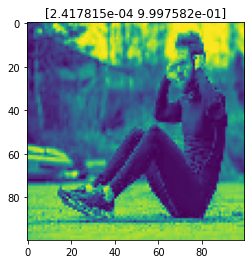

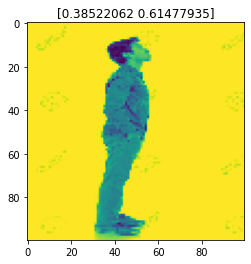

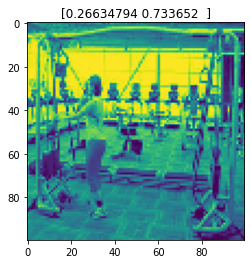

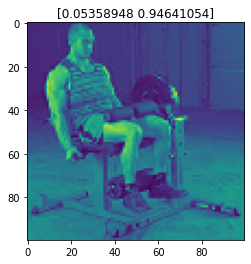

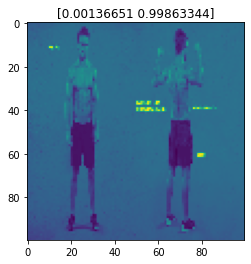

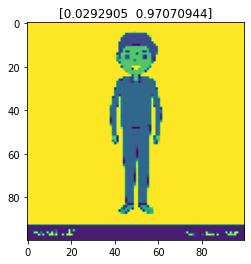

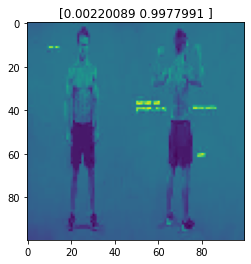

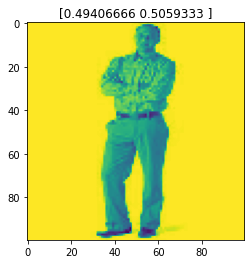

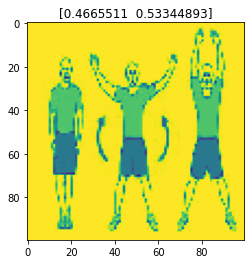

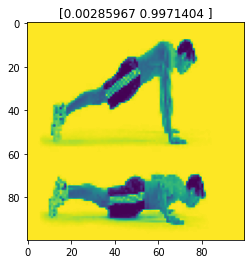

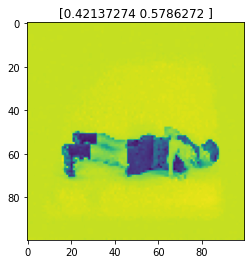

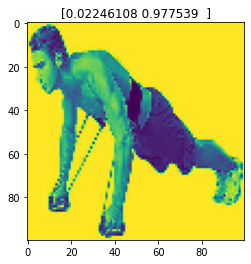

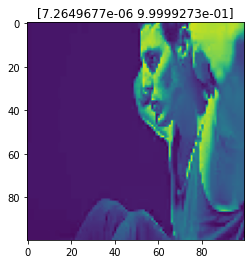

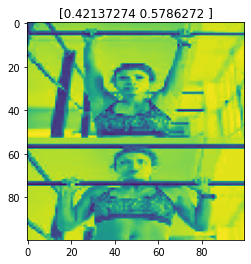

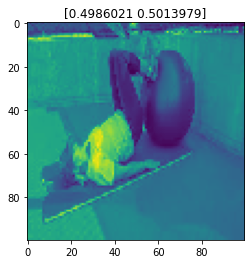

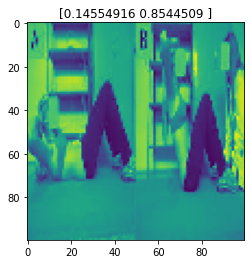

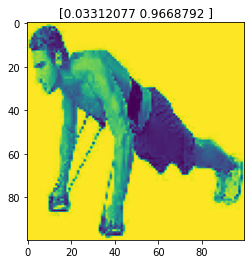

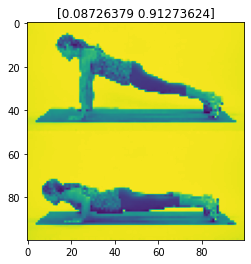

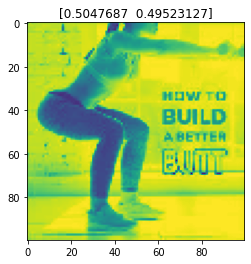

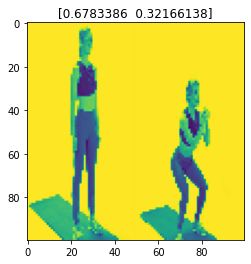

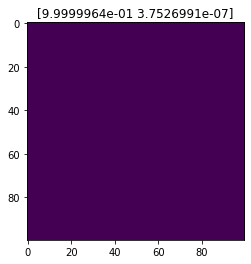

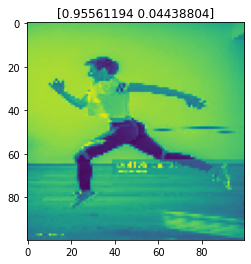

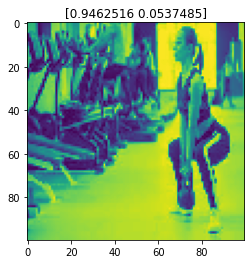

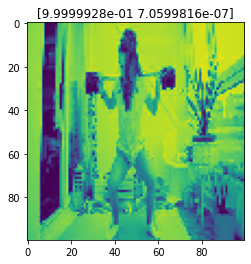

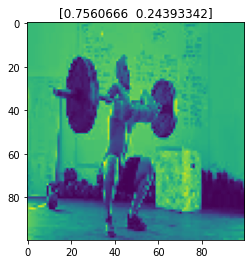

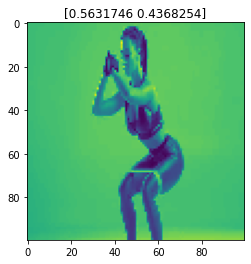

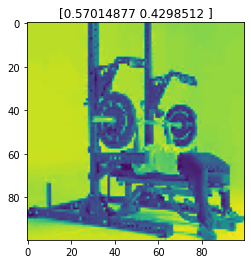

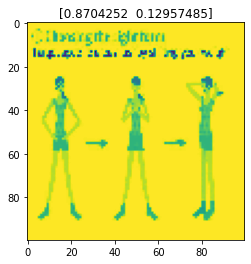

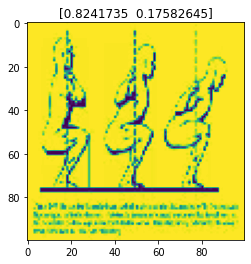

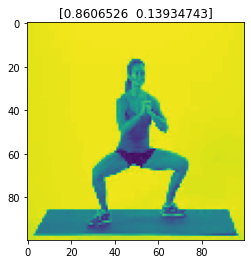

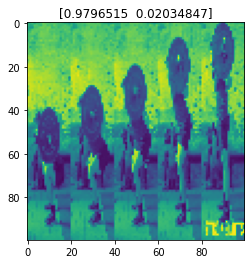

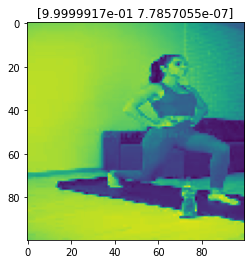

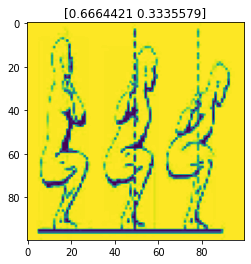

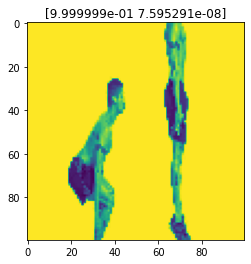

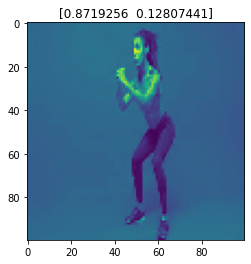

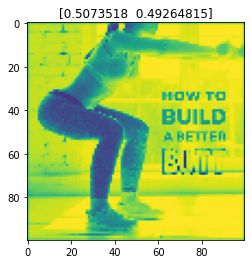

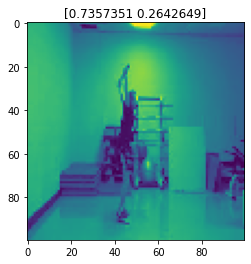

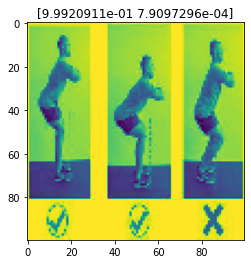

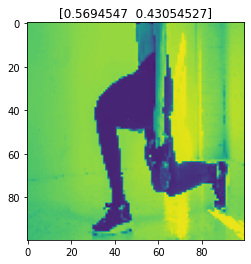

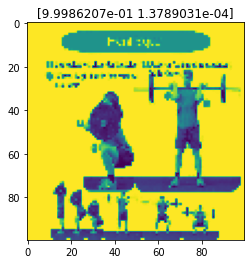

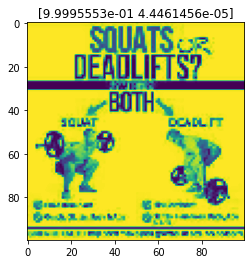

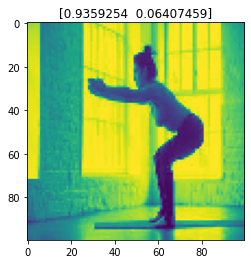

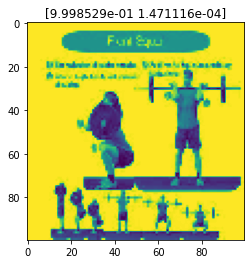

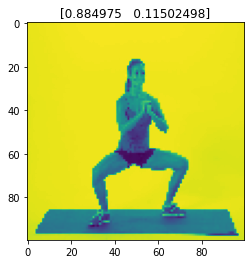

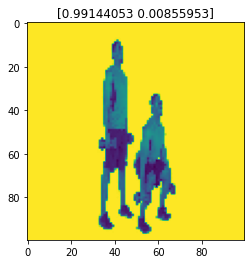

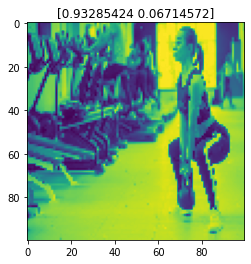

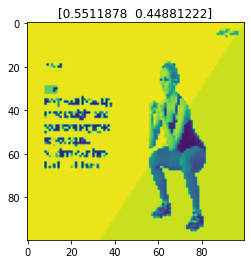

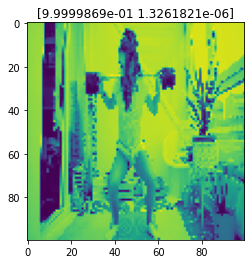

In [28]:
def decoder(one_pred):
    if one_pred[0] > one_pred[1]:
        return np.float32([1,0])
    else:
        return [0,1]

squat_preds = model.predict(X)
decoded = np.apply_along_axis(decoder, 1, squat_preds)

incorrect_squats = []
incorrect_non_squats = []

for i in range(len(Y)):
    if np.array_equal(decoded[i],Y[i]) == False:
        if Y[i][0] == 1:
            incorrect_non_squats.append(i)
        else:
            incorrect_squats.append(i)

            
print(len(incorrect_squats))
print(len(incorrect_non_squats))

for i in incorrect_non_squats:
    plt.imshow(image.array_to_img(X[i,:,:,:])) 
    plt.title(str(squat_preds[i]))
    plt.show()


for i in incorrect_squats:
    plt.imshow(image.array_to_img(X[i,:,:,:])) 
    plt.title(str(squat_preds[i]))
    plt.show()